In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import sys

In [2]:
# import ktrain and ktrain.vision modules
import ktrain
from ktrain import vision

Using TensorFlow backend.


Download a PNG version of the **MNIST** dataset from [here](https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz) and set DATADIR to the extracted folder.

In [3]:
# load the data with some modest data augmentation
# We load as RGB even though we have grayscale images
# since some models only support RGB images.
DATADIR = 'data/mnist_png'
data_aug = vision.get_data_aug(featurewise_center=True, 
                              featurewise_std_normalization=True,
                               rotation_range=15,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1)
(train_data, val_data, preproc) = vision.images_from_folder(
                                              datadir=DATADIR,
                                              data_aug = data_aug,
                                              train_test_names=['training', 'testing'], 
                                              target_size=(32,32), color_mode='rgb')

color_mode detected (grayscale) different than color_mode selected (rgb)
Found 60000 images belonging to 10 classes.
Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [4]:
# get a pre-canned 22-layer Wide Residual Network model
model = vision.image_classifier('wrn22', train_data, val_data)

Is Multi-Label? False
wrn22 model created.


In [5]:
# get a Learner object
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=True, batch_size=64)

In [7]:
# find a good learning rate
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
937/937 [==============================] - 65s 69ms/step - loss: 6.9835 - acc: 0.1659
Epoch 2/5
937/937 [==============================] - 59s 63ms/step - loss: 5.1547 - acc: 0.6753
Epoch 3/5
937/937 [==============================] - 59s 63ms/step - loss: 0.9958 - acc: 0.9507
Epoch 4/5
756/937 [=======================>......] - ETA: 11s - loss: 1.4162 - acc: 0.8885

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


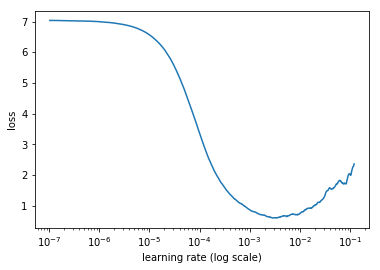

In [8]:
learner.lr_plot()

In [6]:
# train WRN-22 model for a single epoch
learner.autofit(2e-3, 1)



begin training using triangular learning rate policy with max lr of 0.002...
Epoch 1/1
937/937 [==============================] - 67s 71ms/step - loss: 1.0942 - acc: 0.9207 - val_loss: 0.2455 - val_acc: 0.9932


In [7]:
# get a Predictor object that we can use to classify (potentially unlabeled) images
predictor = ktrain.get_predictor(learner.model, preproc)

In [11]:
# let's see the class labels and their indices
predictor.get_classes()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [27]:
# let's try to predict an image depicting a 7
predictor.predict_filename('/home/amaiya/data/mnist_png/testing/7/7021.png')

['7']

In [28]:
# let's try predicting an image showing a 0 and return probabilities for all classes
predictor.predict_filename('/home/amaiya/data/mnist_png/testing/0/101.png', return_proba=True)

array([[9.99729097e-01, 1.02616505e-05, 4.12802947e-05, 1.04568608e-05,
        5.07383811e-06, 3.03435208e-05, 1.10756089e-04, 2.12177038e-05,
        1.56492970e-05, 2.57711799e-05]], dtype=float32)

In [29]:
# let's predict all images showing a 3 in our validation set
predictor.predict_folder('/home/amaiya/data/mnist_png/testing/3/')[:10]

Found 1010 images belonging to 1 classes.


[('3/1020.png', '3'),
 ('3/1028.png', '3'),
 ('3/1042.png', '3'),
 ('3/1062.png', '3'),
 ('3/1066.png', '3'),
 ('3/1067.png', '3'),
 ('3/1069.png', '3'),
 ('3/1072.png', '3'),
 ('3/1092.png', '3'),
 ('3/1095.png', '3')]

In [30]:
# let's save the predictor for possible later deployment in an application
predictor.save('/tmp/mypredictor')

In [31]:
# reload the predictor from a file
predictor = ktrain.load_predictor('/tmp/mypredictor')

In [32]:
# let's use the reloaded predictor to verify it still works correctly
predictor.predict_filename('/home/amaiya/data/mnist_png/testing/7/7021.png')

['7']